In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

v003.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

Using backend: pytorch



True

In [ ]:
bioqic = mre_pinn.data.BIOQICFEMBox('../data/BIOQIC/downloads')
bioqic.download()
bioqic.load_mat()
bioqic.preprocess()
dataset = bioqic.to_dataset()
dataset.save_xarrays('../data/BIOQIC/fem_box')

In [3]:
example = mre_pinn.data.MREExample.load_xarrays('../data/BIOQIC/fem_box', 60)
example.metadata

Loading ../data/BIOQIC/fem_box/60/wave.nc
Loading ../data/BIOQIC/fem_box/60/mre.nc
Loading ../data/BIOQIC/fem_box/60/mre_mask.nc


size  spacing  origin  limit  center  extent
variable dimension                                              
wave     x            80    0.001     0.0  0.079  0.0395    0.08
         y           100    0.001     0.0  0.099  0.0495    0.10
         z            10    0.001     0.0  0.009  0.0045    0.01
mre      x            80    0.001     0.0  0.079  0.0395    0.08
         y           100    0.001     0.0  0.099  0.0495    0.10
         z            10    0.001     0.0  0.009  0.0045    0.01
mre_mask x            80    0.001     0.0  0.079  0.0395    0.08
         y           100    0.001     0.0  0.099  0.0495    0.10
         z            10    0.001     0.0  0.009  0.0045    0.01

In [4]:
example.describe()

dtype    count                     mean          std  \
variable component                                                              
wave     y          complex128  80000.0  -0.00000100-0.00001000j     0.000724   
         x          complex128  80000.0   0.00022200-0.00020700j     0.000742   
         z          complex128  80000.0   0.00092400+0.00005900j     0.012493   
mre      scalar     complex128  80000.0  3362.250000+376.991118j  1550.653068   
mre_mask scalar          int64  80000.0   1.06650000+0.00000000j     0.313174   

                                        min                      25%  \
variable component                                                     
wave     y          -0.00198900-0.00084800j  -0.00031600+0.00029700j   
         x          -0.00271700+0.00009800j  -0.00007000-0.00019200j   
         z          -0.02294100-0.00252200j  -0.00443200-0.00007700j   
mre      scalar     3000.000000+376.991118j  3000.000000+376.991118j   
mre_mask scalar      1.00000000+0.00000000j   1.00000000+0.00000000j   

                                        50%                      75%  \
variable component                                                     
wave     y           0.00002900+0.00024900j   0.00031500+0.00007300j   
         x           0.00017900+0.00008700j   0.00053800-0.00078400j   
         z           0.00069400+0.00010000j   0.00689700-0.01260300j   
mre      scalar     3000.000000+376.991118j  3000.000000+376.991118j   
mre_mask scalar      1.00000000+0.00000000j   1.00000000+0.00000000j   

                                         max  
variable component                            
wave     y          0.001772000+0.000765000j  
         x          0.002784000-0.001559000j  
         z          0.022754000+0.005157000j  
mre      scalar     10000.000000+376.991118j  
mre_mask scalar     5.000000000+0.000000000j

<IPython.core.display.Javascript object>


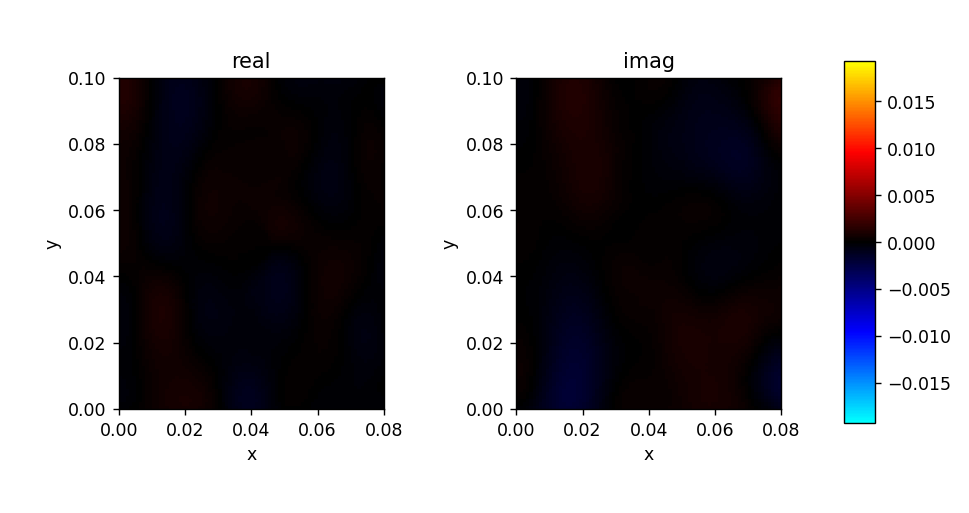

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


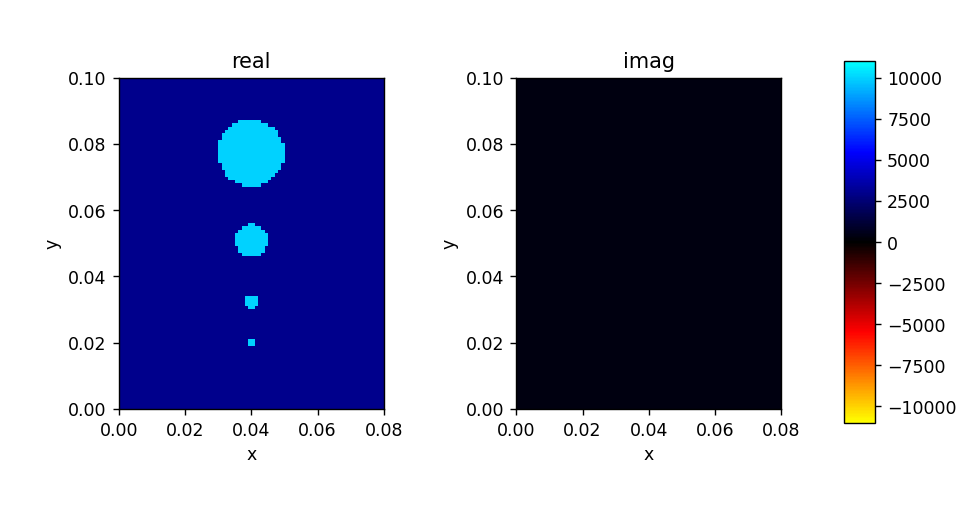

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


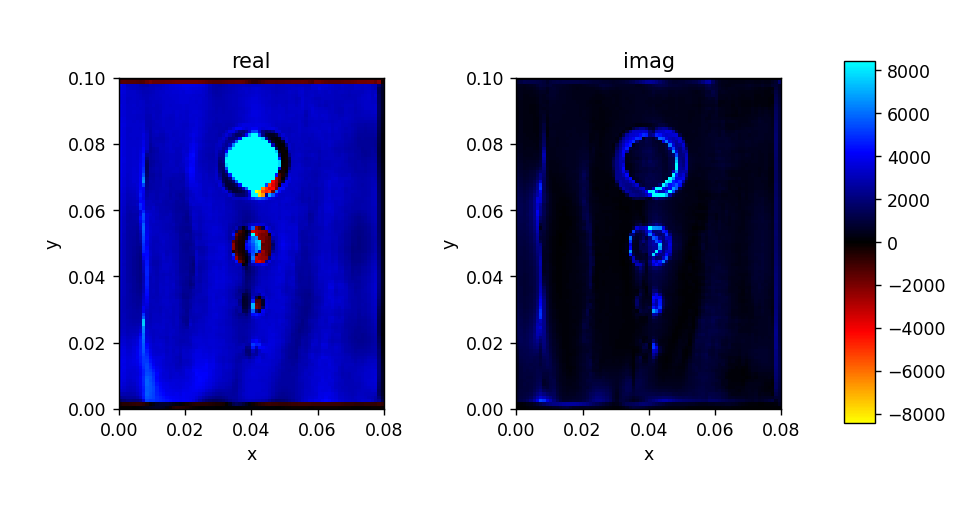

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

In [5]:
example.eval_baseline(frequency=example.wave.frequency.item(), polar=True)
example.view('wave', 'mre', 'base', ax_height=3, col='part', polar=False)

In [50]:
pde = mre_pinn.pde.WaveEquation.from_name('helmholtz', omega=example.wave.frequency.item(), detach=True)

In [56]:
%autoreload
pinn = mre_pinn.model.MREPINN(
    example,
    omega=15,
    n_layers=4,
    n_hidden=128,
    polar_input=False,
    polar_output=False,
    conditional=False
)
pinn

MREPINN(
  (u_pinn): PINN(
    (hidden0): Linear(in_features=3, out_features=128, bias=True)
    (hidden1): Linear(in_features=131, out_features=128, bias=True)
    (hidden2): Linear(in_features=259, out_features=128, bias=True)
    (output): Linear(in_features=387, out_features=6, bias=True)
  )
  (mu_pinn): PINN(
    (hidden0): Linear(in_features=3, out_features=128, bias=True)
    (hidden1): Linear(in_features=131, out_features=128, bias=True)
    (hidden2): Linear(in_features=259, out_features=128, bias=True)
    (output): Linear(in_features=387, out_features=2, bias=True)
  )
)

In [62]:
%autoreload
model = mre_pinn.training.MREPINNModel(example, pinn, pde, loss_weights=[1, 0, 0], n_points=4096)
model.compile(optimizer='adam', lr=1e-5, loss=mre_pinn.training.losses.msae_loss)

Compiling model...
'compile' took 0.000188 s



In [63]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
model.benchmark(100)

# iterations: 100
Data time/iter:  0.0004s (0.92%)
Model time/iter: 0.0006s (1.34%)
Loss time/iter:  0.0439s (97.74%)
Total time/iter: 0.0449s
Total time: 4.4902s
1k iters time: 0.75m
10k iters time: 7.48m
100k iters time: 1.25h


<IPython.core.display.Javascript object>


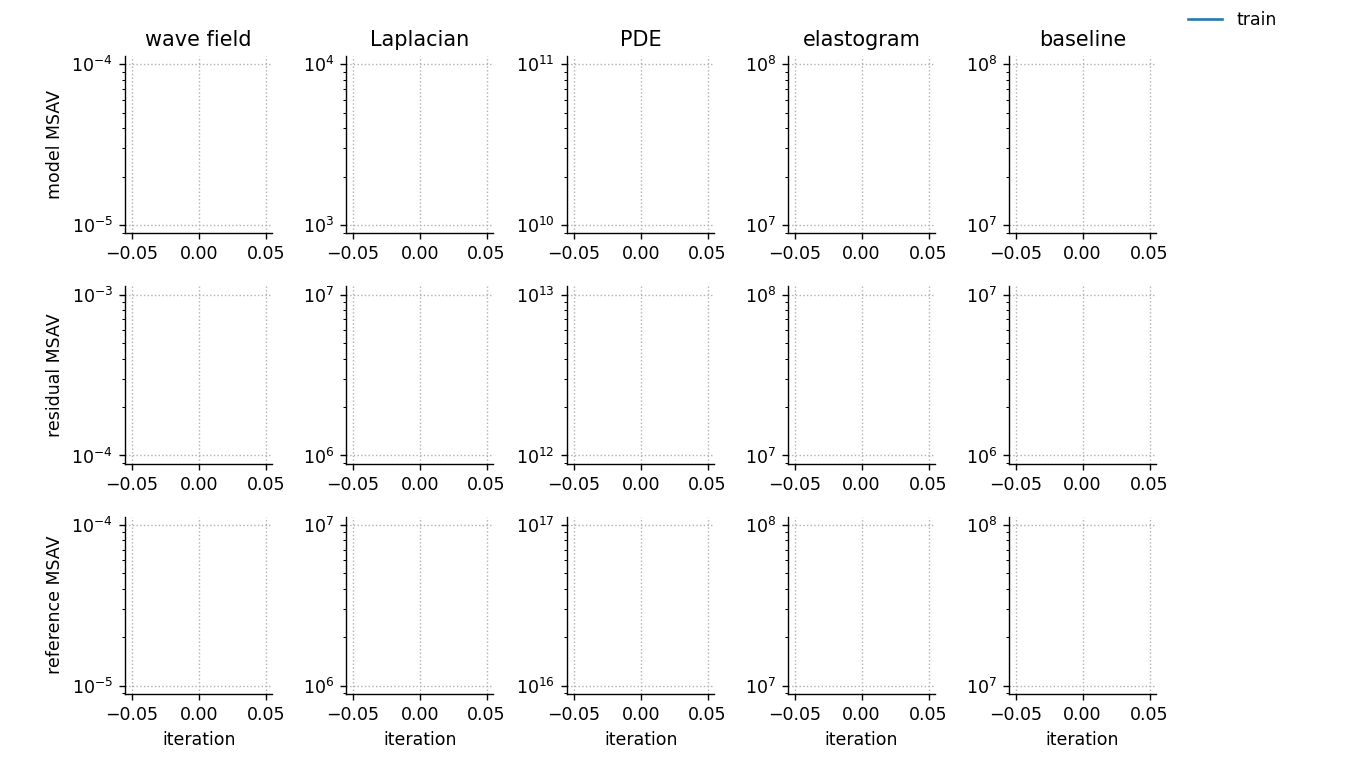

<IPython.core.display.Javascript object>


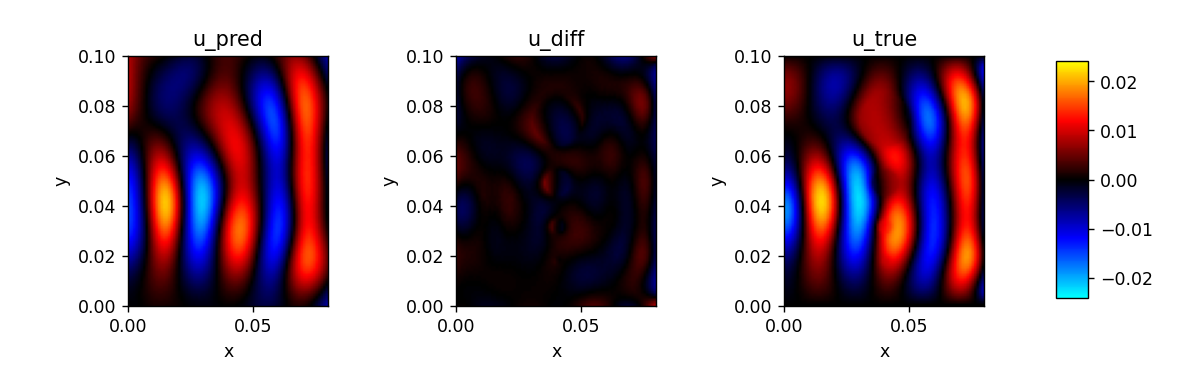

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


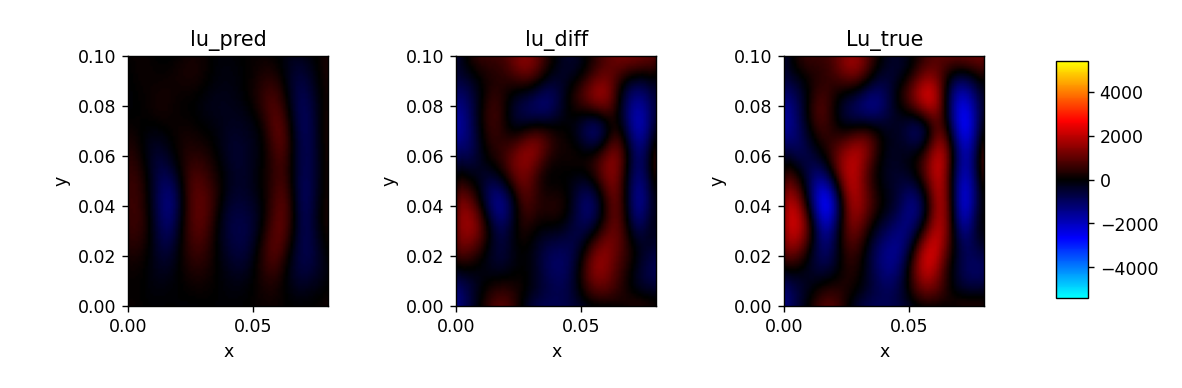

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


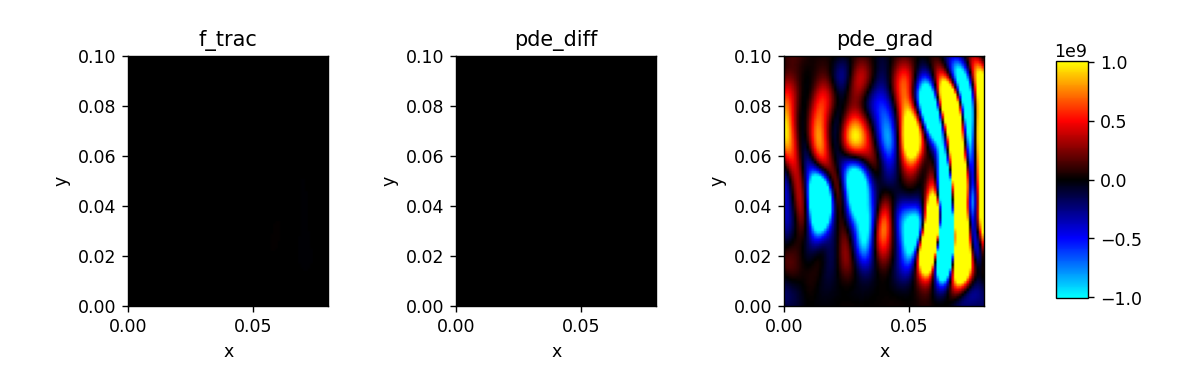

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


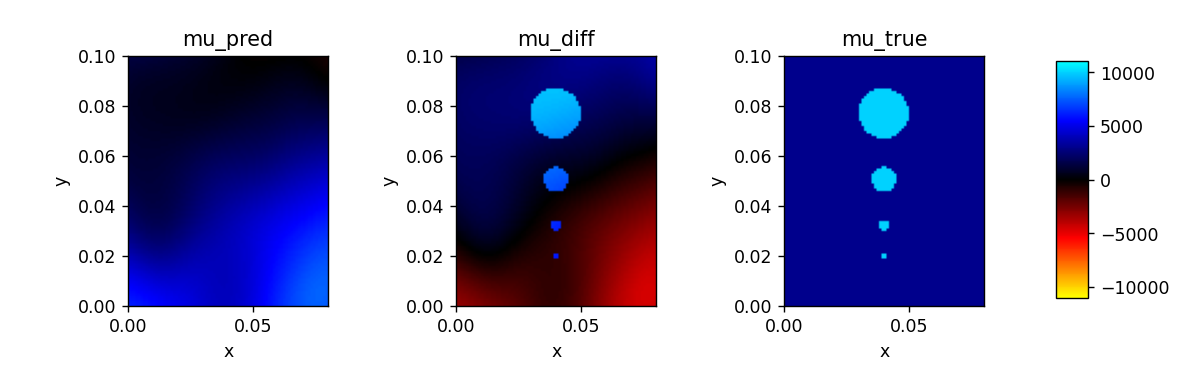

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


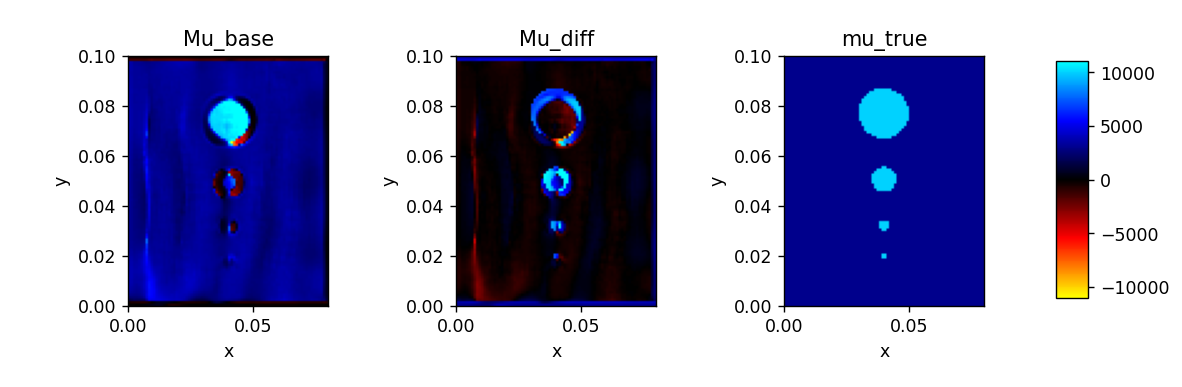

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [65]:
test_eval = mre_pinn.testing.TestEvaluator(test_every=100, interact=True)
test_eval.model = model
test_eval.test()

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.58e-04, 0.00e+00, 0.00e+00]    [1.56e-04, 0.00e+00, 0.00e+00]    []  


<IPython.core.display.Javascript object>


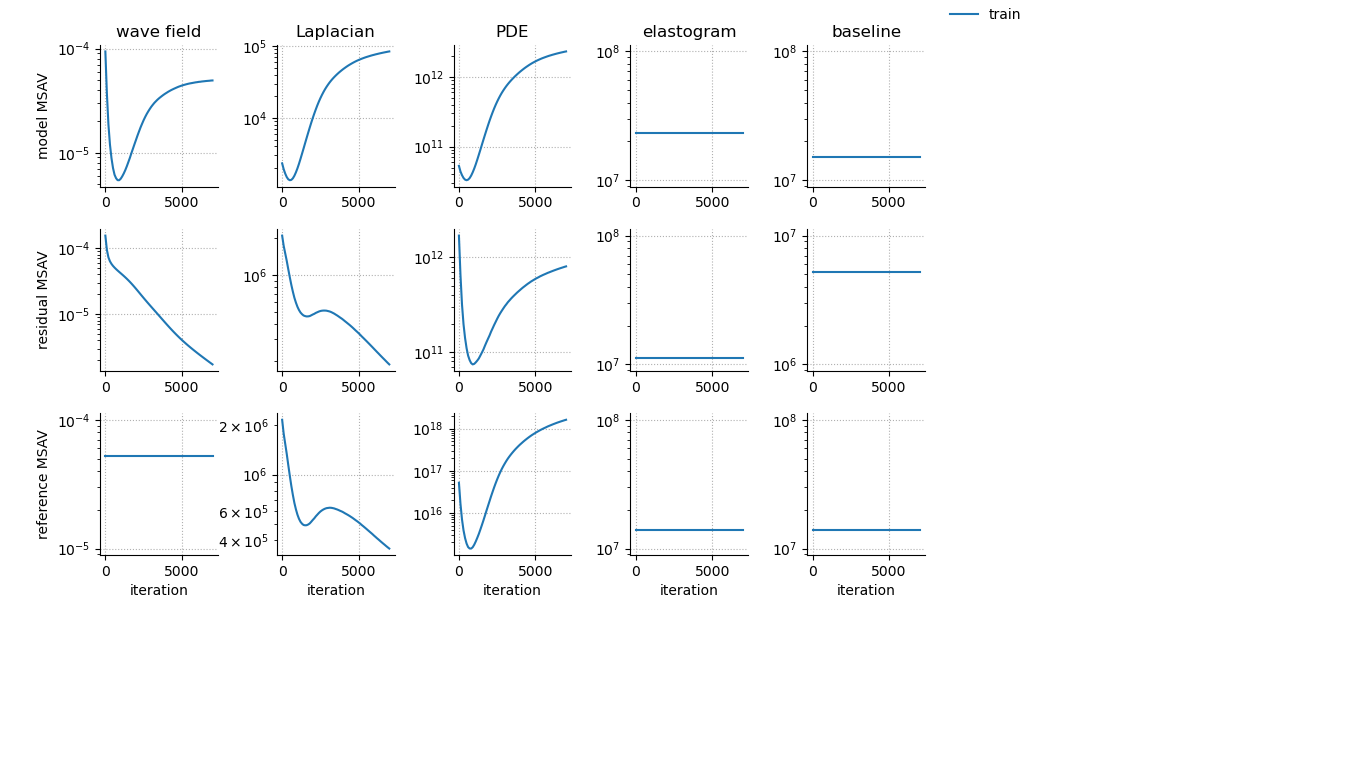

Time spent testing: 7.2299 (17.52%)
10        [1.46e-04, 0.00e+00, 0.00e+00]    [1.47e-04, 0.00e+00, 0.00e+00]    []  
20        [1.35e-04, 0.00e+00, 0.00e+00]    [1.38e-04, 0.00e+00, 0.00e+00]    []  
30        [1.29e-04, 0.00e+00, 0.00e+00]    [1.31e-04, 0.00e+00, 0.00e+00]    []  
40        [1.27e-04, 0.00e+00, 0.00e+00]    [1.24e-04, 0.00e+00, 0.00e+00]    []  
50        [1.16e-04, 0.00e+00, 0.00e+00]    [1.17e-04, 0.00e+00, 0.00e+00]    []  
60        [1.13e-04, 0.00e+00, 0.00e+00]    [1.12e-04, 0.00e+00, 0.00e+00]    []  
70        [1.05e-04, 0.00e+00, 0.00e+00]    [1.07e-04, 0.00e+00, 0.00e+00]    []  
80        [1.01e-04, 0.00e+00, 0.00e+00]    [1.02e-04, 0.00e+00, 0.00e+00]    []  
90        [9.62e-05, 0.00e+00, 0.00e+00]    [9.81e-05, 0.00e+00, 0.00e+00]    []  
100       [9.38e-05, 0.00e+00, 0.00e+00]    [9.45e-05, 0.00e+00, 0.00e+00]    []  
Time spent testing: 7.2891 (27.05%)
110       [9.25e-05, 0.00e+00, 0.00e+00]    [9.12e-05, 0.00e+00, 0.00e+00]    []  
120       [8.60

960       [4.18e-05, 0.00e+00, 0.00e+00]    [4.33e-05, 0.00e+00, 0.00e+00]    []  
970       [4.28e-05, 0.00e+00, 0.00e+00]    [4.31e-05, 0.00e+00, 0.00e+00]    []  
980       [4.13e-05, 0.00e+00, 0.00e+00]    [4.29e-05, 0.00e+00, 0.00e+00]    []  
990       [4.23e-05, 0.00e+00, 0.00e+00]    [4.27e-05, 0.00e+00, 0.00e+00]    []  
1000      [4.17e-05, 0.00e+00, 0.00e+00]    [4.25e-05, 0.00e+00, 0.00e+00]    []  
Time spent testing: 6.8131 (46.94%)
1010      [4.13e-05, 0.00e+00, 0.00e+00]    [4.23e-05, 0.00e+00, 0.00e+00]    []  
1020      [4.11e-05, 0.00e+00, 0.00e+00]    [4.21e-05, 0.00e+00, 0.00e+00]    []  
1030      [4.12e-05, 0.00e+00, 0.00e+00]    [4.19e-05, 0.00e+00, 0.00e+00]    []  
1040      [4.18e-05, 0.00e+00, 0.00e+00]    [4.17e-05, 0.00e+00, 0.00e+00]    []  
1050      [4.08e-05, 0.00e+00, 0.00e+00]    [4.16e-05, 0.00e+00, 0.00e+00]    []  
1060      [4.19e-05, 0.00e+00, 0.00e+00]    [4.14e-05, 0.00e+00, 0.00e+00]    []  
1070      [3.93e-05, 0.00e+00, 0.00e+00]    [4.12e-

Time spent testing: 6.8541 (50.83%)
1910      [2.57e-05, 0.00e+00, 0.00e+00]    [2.62e-05, 0.00e+00, 0.00e+00]    []  
1920      [2.56e-05, 0.00e+00, 0.00e+00]    [2.60e-05, 0.00e+00, 0.00e+00]    []  
1930      [2.53e-05, 0.00e+00, 0.00e+00]    [2.59e-05, 0.00e+00, 0.00e+00]    []  
1940      [2.52e-05, 0.00e+00, 0.00e+00]    [2.57e-05, 0.00e+00, 0.00e+00]    []  
1950      [2.46e-05, 0.00e+00, 0.00e+00]    [2.56e-05, 0.00e+00, 0.00e+00]    []  
1960      [2.54e-05, 0.00e+00, 0.00e+00]    [2.54e-05, 0.00e+00, 0.00e+00]    []  
1970      [2.44e-05, 0.00e+00, 0.00e+00]    [2.52e-05, 0.00e+00, 0.00e+00]    []  
1980      [2.55e-05, 0.00e+00, 0.00e+00]    [2.51e-05, 0.00e+00, 0.00e+00]    []  
1990      [2.43e-05, 0.00e+00, 0.00e+00]    [2.49e-05, 0.00e+00, 0.00e+00]    []  
2000      [2.45e-05, 0.00e+00, 0.00e+00]    [2.48e-05, 0.00e+00, 0.00e+00]    []  
Time spent testing: 6.8700 (51.06%)
2010      [2.37e-05, 0.00e+00, 0.00e+00]    [2.46e-05, 0.00e+00, 0.00e+00]    []  
2020      [2.46

2860      [1.42e-05, 0.00e+00, 0.00e+00]    [1.43e-05, 0.00e+00, 0.00e+00]    []  
2870      [1.44e-05, 0.00e+00, 0.00e+00]    [1.42e-05, 0.00e+00, 0.00e+00]    []  
2880      [1.36e-05, 0.00e+00, 0.00e+00]    [1.41e-05, 0.00e+00, 0.00e+00]    []  
2890      [1.36e-05, 0.00e+00, 0.00e+00]    [1.40e-05, 0.00e+00, 0.00e+00]    []  
2900      [1.37e-05, 0.00e+00, 0.00e+00]    [1.39e-05, 0.00e+00, 0.00e+00]    []  
Time spent testing: 6.7163 (52.59%)
2910      [1.37e-05, 0.00e+00, 0.00e+00]    [1.39e-05, 0.00e+00, 0.00e+00]    []  
2920      [1.37e-05, 0.00e+00, 0.00e+00]    [1.38e-05, 0.00e+00, 0.00e+00]    []  
2930      [1.34e-05, 0.00e+00, 0.00e+00]    [1.37e-05, 0.00e+00, 0.00e+00]    []  
2940      [1.35e-05, 0.00e+00, 0.00e+00]    [1.36e-05, 0.00e+00, 0.00e+00]    []  
2950      [1.33e-05, 0.00e+00, 0.00e+00]    [1.35e-05, 0.00e+00, 0.00e+00]    []  
2960      [1.32e-05, 0.00e+00, 0.00e+00]    [1.34e-05, 0.00e+00, 0.00e+00]    []  
2970      [1.33e-05, 0.00e+00, 0.00e+00]    [1.34e-

Time spent testing: 6.5754 (53.55%)
3810      [7.96e-06, 0.00e+00, 0.00e+00]    [7.97e-06, 0.00e+00, 0.00e+00]    []  
3820      [7.96e-06, 0.00e+00, 0.00e+00]    [7.92e-06, 0.00e+00, 0.00e+00]    []  
3830      [7.73e-06, 0.00e+00, 0.00e+00]    [7.87e-06, 0.00e+00, 0.00e+00]    []  
3840      [8.09e-06, 0.00e+00, 0.00e+00]    [7.82e-06, 0.00e+00, 0.00e+00]    []  
3850      [7.77e-06, 0.00e+00, 0.00e+00]    [7.77e-06, 0.00e+00, 0.00e+00]    []  
3860      [7.57e-06, 0.00e+00, 0.00e+00]    [7.72e-06, 0.00e+00, 0.00e+00]    []  
3870      [7.58e-06, 0.00e+00, 0.00e+00]    [7.67e-06, 0.00e+00, 0.00e+00]    []  
3880      [7.36e-06, 0.00e+00, 0.00e+00]    [7.63e-06, 0.00e+00, 0.00e+00]    []  
3890      [7.45e-06, 0.00e+00, 0.00e+00]    [7.58e-06, 0.00e+00, 0.00e+00]    []  
3900      [7.81e-06, 0.00e+00, 0.00e+00]    [7.54e-06, 0.00e+00, 0.00e+00]    []  
Time spent testing: 6.5150 (53.62%)
3910      [7.35e-06, 0.00e+00, 0.00e+00]    [7.49e-06, 0.00e+00, 0.00e+00]    []  
3920      [7.36

4760      [4.57e-06, 0.00e+00, 0.00e+00]    [4.57e-06, 0.00e+00, 0.00e+00]    []  
4770      [4.50e-06, 0.00e+00, 0.00e+00]    [4.54e-06, 0.00e+00, 0.00e+00]    []  
4780      [4.52e-06, 0.00e+00, 0.00e+00]    [4.52e-06, 0.00e+00, 0.00e+00]    []  
4790      [4.40e-06, 0.00e+00, 0.00e+00]    [4.50e-06, 0.00e+00, 0.00e+00]    []  
4800      [4.47e-06, 0.00e+00, 0.00e+00]    [4.47e-06, 0.00e+00, 0.00e+00]    []  
Time spent testing: 7.0557 (54.25%)
4810      [4.32e-06, 0.00e+00, 0.00e+00]    [4.45e-06, 0.00e+00, 0.00e+00]    []  
4820      [4.39e-06, 0.00e+00, 0.00e+00]    [4.43e-06, 0.00e+00, 0.00e+00]    []  
4830      [4.46e-06, 0.00e+00, 0.00e+00]    [4.41e-06, 0.00e+00, 0.00e+00]    []  
4840      [4.34e-06, 0.00e+00, 0.00e+00]    [4.38e-06, 0.00e+00, 0.00e+00]    []  
4850      [4.39e-06, 0.00e+00, 0.00e+00]    [4.36e-06, 0.00e+00, 0.00e+00]    []  
4860      [4.51e-06, 0.00e+00, 0.00e+00]    [4.34e-06, 0.00e+00, 0.00e+00]    []  
4870      [4.50e-06, 0.00e+00, 0.00e+00]    [4.32e-

Time spent testing: 7.1430 (54.62%)
5710      [2.98e-06, 0.00e+00, 0.00e+00]    [2.90e-06, 0.00e+00, 0.00e+00]    []  
5720      [3.05e-06, 0.00e+00, 0.00e+00]    [2.89e-06, 0.00e+00, 0.00e+00]    []  
5730      [2.94e-06, 0.00e+00, 0.00e+00]    [2.88e-06, 0.00e+00, 0.00e+00]    []  
5740      [2.96e-06, 0.00e+00, 0.00e+00]    [2.87e-06, 0.00e+00, 0.00e+00]    []  
5750      [2.85e-06, 0.00e+00, 0.00e+00]    [2.85e-06, 0.00e+00, 0.00e+00]    []  
5760      [2.92e-06, 0.00e+00, 0.00e+00]    [2.84e-06, 0.00e+00, 0.00e+00]    []  
5770      [2.87e-06, 0.00e+00, 0.00e+00]    [2.83e-06, 0.00e+00, 0.00e+00]    []  
5780      [2.86e-06, 0.00e+00, 0.00e+00]    [2.81e-06, 0.00e+00, 0.00e+00]    []  
5790      [2.78e-06, 0.00e+00, 0.00e+00]    [2.80e-06, 0.00e+00, 0.00e+00]    []  
5800      [2.87e-06, 0.00e+00, 0.00e+00]    [2.79e-06, 0.00e+00, 0.00e+00]    []  
Time spent testing: 6.5881 (54.65%)
5810      [2.83e-06, 0.00e+00, 0.00e+00]    [2.78e-06, 0.00e+00, 0.00e+00]    []  
5820      [2.76

6660      [2.00e-06, 0.00e+00, 0.00e+00]    [1.96e-06, 0.00e+00, 0.00e+00]    []  
6670      [2.04e-06, 0.00e+00, 0.00e+00]    [1.96e-06, 0.00e+00, 0.00e+00]    []  
6680      [2.04e-06, 0.00e+00, 0.00e+00]    [1.95e-06, 0.00e+00, 0.00e+00]    []  
6690      [1.95e-06, 0.00e+00, 0.00e+00]    [1.94e-06, 0.00e+00, 0.00e+00]    []  
6700      [1.96e-06, 0.00e+00, 0.00e+00]    [1.93e-06, 0.00e+00, 0.00e+00]    []  
Time spent testing: 6.5405 (54.97%)
6710      [1.94e-06, 0.00e+00, 0.00e+00]    [1.92e-06, 0.00e+00, 0.00e+00]    []  
6720      [1.96e-06, 0.00e+00, 0.00e+00]    [1.92e-06, 0.00e+00, 0.00e+00]    []  
6730      [1.98e-06, 0.00e+00, 0.00e+00]    [1.91e-06, 0.00e+00, 0.00e+00]    []  
6740      [1.99e-06, 0.00e+00, 0.00e+00]    [1.90e-06, 0.00e+00, 0.00e+00]    []  
6750      [1.88e-06, 0.00e+00, 0.00e+00]    [1.89e-06, 0.00e+00, 0.00e+00]    []  
6760      [1.92e-06, 0.00e+00, 0.00e+00]    [1.89e-06, 0.00e+00, 0.00e+00]    []  
6770      [1.92e-06, 0.00e+00, 0.00e+00]    [1.88e-

In [ ]:
model.train(10000, display_every=10, callbacks=[test_eval])